In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
import datetime

2023-09-22 14:43:46.811013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [2]:
# Dataset Parameters
root = './dataset/'
batch_size = 32
img_height = 256
img_width = 256
seed = 123

In [3]:
# importing the training split
train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4757 files belonging to 29 classes.
Using 3806 files for training.


2023-09-22 14:43:59.008610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 14:43:59.059878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 14:43:59.059939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 14:43:59.062049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 14:43:59.062121: I tensorflow/compile

In [4]:
# importing the validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4757 files belonging to 29 classes.
Using 951 files for validation.


# Hyperparameter initialisation and Dataset finalization

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [6]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Chickenpox', 'Cowpox', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'HFMD', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Healthy', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Measles', 'Melanoma Skin Cancer Nevi and Moles', 'Monkeypox', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
29


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [8]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


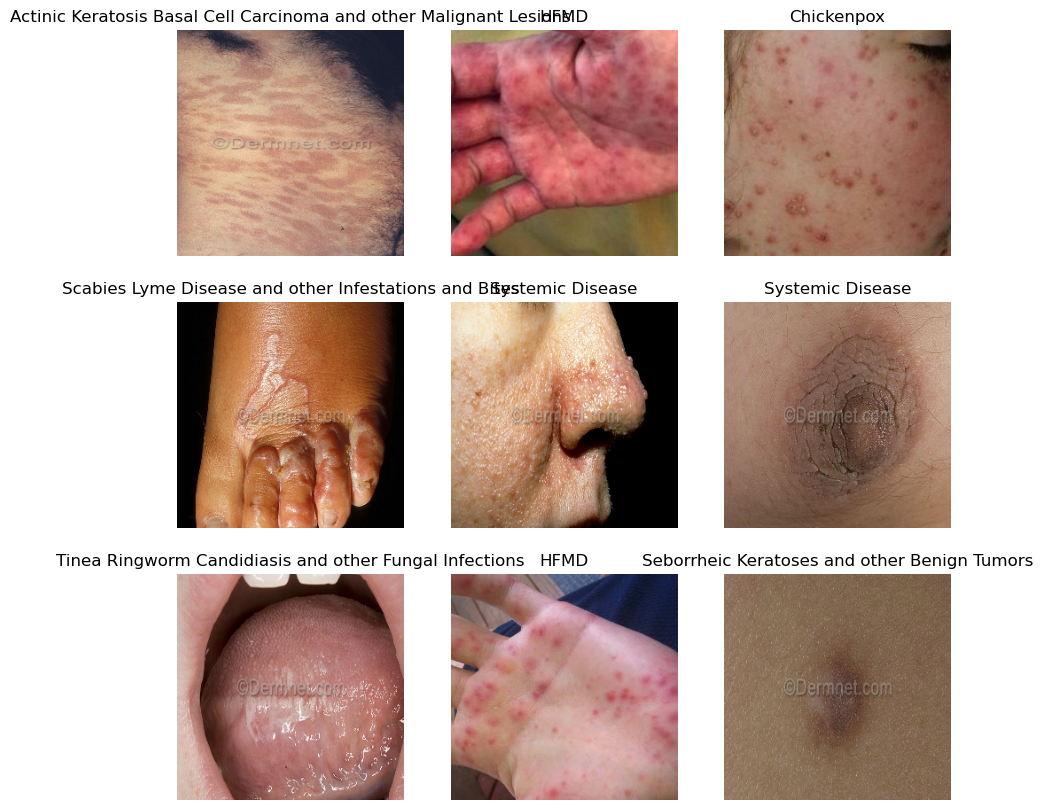

In [9]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [10]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 6, (3, 3), activation='relu'),
  tf.keras.layers.Conv2D(64, 12, (3, 3), activation='relu'),
  tf.keras.layers.Conv2D(32, 18, (2, 2), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16 * num_classes, activation='relu'),
  tf.keras.layers.Dense(8 * num_classes, activation='relu'),
  tf.keras.layers.Dense(2 * num_classes, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25,
  callbacks=[tensorboard_callback]
)

Epoch 1/25
119/119 [==============================] - 14s 88ms/step - loss: 3.2821 - accuracy: 0.0633 - val_loss: 3.2426 - val_accuracy: 0.0673
Epoch 2/25
119/119 [==============================] - 10s 76ms/step - loss: 3.2108 - accuracy: 0.0681 - val_loss: 3.2047 - val_accuracy: 0.0568
Epoch 3/25
119/119 [==============================] - 9s 74ms/step - loss: 3.1985 - accuracy: 0.0775 - val_loss: 3.1747 - val_accuracy: 0.0831
Epoch 4/25
119/119 [==============================] - 10s 79ms/step - loss: 3.1773 - accuracy: 0.0864 - val_loss: 3.1663 - val_accuracy: 0.0715
Epoch 5/25
119/119 [==============================] - 10s 77ms/step - loss: 3.1251 - accuracy: 0.1104 - val_loss: 3.1037 - val_accuracy: 0.1125
Epoch 6/25
119/119 [==============================] - 10s 77ms/step - loss: 3.0845 - accuracy: 0.1217 - val_loss: 3.0916 - val_accuracy: 0.1146
Epoch 7/25
119/119 [==============================] - 10s 81ms/step - loss: 3.1139 - accuracy: 0.1109 - val_loss: 3.1133 - val_accuracy: 

In [25]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

30/30 [==============================] - 2s 47ms/step - loss: 3.1916 - accuracy: 0.0673


[3.191605567932129, 0.06729757785797119]

In [26]:
images = []
labels = []

for x, y in val_ds.unbatch():
    images.append(x)
    labels.append(np.array(y).item())

In [27]:
test = np.array(images)

In [28]:
y_pred = (model.predict(test)).argmax(axis=1)

30/30 [==============================] - 1s 17ms/step


In [29]:
y_pred

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.00      0.00      0.00        52
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        57
                                          Atopic Dermatitis Photos       0.00      0.00      0.00        23
                                            Bullous Disease Photos       0.00      0.00      0.00        21
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        16
                                                        Chickenpox       0.00      0.00      0.00        14
                                                            Cowpox       0.00      0.00      0.00         3
                                                     Eczema Photos       

/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 128)       13952     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        1179712   
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 32)          663584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                      

In [32]:
lmao = model.history

ValueError: 'bottom right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

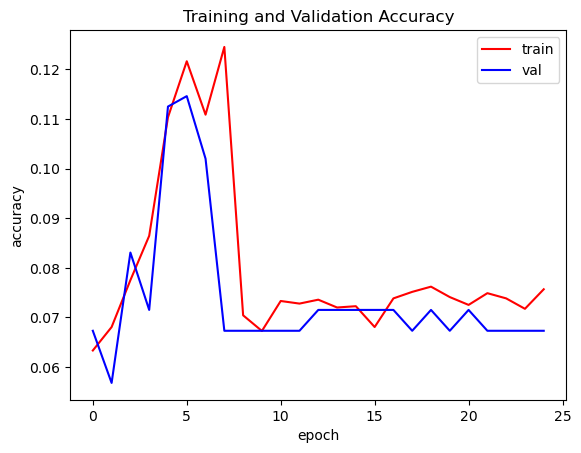

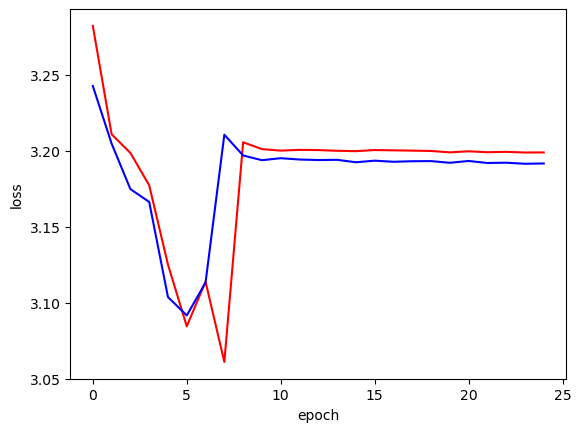

In [33]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.title('Training and Validaion Loss')
plt.figure()

In [ ]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5')

/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
